# ML in Cybersecurity: Task II

## Team
  * **Team name**:  *ChickenEgg*
  * **Members**:  *Sangeet Sagar (sasa00001@stud.uni-saarland.de), Abhijith Srinivas Bidaralli (abbi00001@stud.uni-saarland.de), Abhinav Bhatt (abbh00001@stud.uni-saarland.de)*



## Logistics
  * **Due date**: 25th Nov. 2021, 23:59:59 (email the completed notebook including outputs to mlcysec_ws2022_staff@lists.cispa.saarland)
  * Email the completed notebook to mlcysec_ws2022_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course forum to discuss.
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we ask you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results.

Whenever possible, please use tools like tables or figures to compare the different findings


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

In [2]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
torch.manual_seed(123)

In [3]:
# compute_mode = 'gpu'

# if compute_mode == 'cpu':
#     device = torch.device('cpu')
# elif compute_mode == 'gpu':
#     # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
#     # It is extremely important that you *do not* spawn multi-GPU jobs.
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
#     device = torch.device('cuda:0')
# else:
#     raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [4]:
#
#
# ------- Your Code -------
#
#

# 1. Attacking an ML-model (30 points) 

In this section, we implement an attack ourselves. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from task 1.



## 1.1: Setting up the model and data (4 Points)

Load the MNIST data, as done in task 1. 

Re-use the model from task 1 here and train it until it achieves reasonable accuracy (>92%).

If you have the saved checkpoint from task 1, you can load it directly. But please compute here the test accuracy using this checkpoint.  

**Hint:** In order to save computation time for the rest of exercise, you might consider having a relatively small model here.

**Hint**: You might want to save the trained model to save time later.

### Defining hyperparameters

In [5]:
# (1)load data 
# (2)define model
# (3)define loss, optimizer 
# (4)train (You can re-use the trained model from project1)
# (5)evaluate

#Hyperparameters for the model
batch_size_train = 100 
batch_size_test = 100
n_epochs = 20
learning_rate = 2e-3
input_size=1
hidden_layers=[32,64,128]
drop_prob=0.3
num_classes=10
reg=0.001

#Initialise the weights
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

# Learning rate update functionality        
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr  

### Data Preprocessing

In [6]:
# Prepare the data
print("Loading dataset....")

# Loading the datasets
train_set = torchvision.datasets.MNIST(root='.', train=True, transform=transforms.ToTensor(), download=True)
train_set, valid_set = torch.utils.data.random_split(train_set, [50000, 10000])
test_set = torchvision.datasets.MNIST(root='.', train=False, transform=transforms.ToTensor(), download=True)

# Creating the train loader.
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size_train,
                                           shuffle=True)
# Creating the val loader.
val_loader = torch.utils.data.DataLoader(dataset=valid_set,
                                           batch_size=batch_size_train,
                                           shuffle=False)
# Creating the test loader.
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size_test,
                                          shuffle=False)
print("Done.")

Loading dataset....
Done.


### Model

In [7]:
# Defining the model
class Net(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(Net, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(drop_prob)
        )
        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of second conv layer.
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output  # return x for visualization

### Fit model

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
device

device(type='cuda')

In [10]:
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# Initialise the model
model = Net(input_size, hidden_layers, num_classes).to(device)
model.apply(weights_init)
running_loss = 0.0
loss_plot_y = []
loss_plot_x =[]
loss_plot_val_y = []
loss_plot_val_x =[]
lr = learning_rate
learning_rate_decay = 0.95
accuracy_plot = []
total_step = len(train_loader)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# For all the epochs.
start_cnn = time.time()
for epoch in range(n_epochs):
        model.train()
        for (i, (images, labels)) in enumerate(train_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Loss calculation
            loss = criterion(outputs, labels)

            # zeroing the gradients
            optimizer.zero_grad()
            
            # Backpropagate the loss
            loss.backward()
            
            # Update the weights
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % 50 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch
                        + 1, n_epochs, i + 1, total_step, loss.item()))
        loss_plot_y.append(running_loss / len(train_loader))
                #loss_plot_x.append(epoch * total_step + i)
        running_loss = 0.0
        loss_plot_x.append(epoch)
        lr *= learning_rate_decay
        update_lr(optimizer, lr)
        
        # Doing the validation step.
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for (images, labels) in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                (_, predicted) = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                running_loss += loss.item()
            loss_plot_val_y.append(running_loss / len(val_loader))
            accuracy_plot.append(100 * correct / total)

            print('Validation accuracy is: {} %'.format(100 * correct / total))
            print('-'*20)
        running_loss=0.0

# Testing the model, although we only use the validation accuracy for selecting the best hyperparameters
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        (_, predicted) = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    print ('Accuracy of the network on the test images: {} %'.format(
            100 * correct / total))
end_cnn = time.time()
print("="*20)
print(f"Training runtime: {end_cnn - start_cnn:.3f} s")

# Saving the model
torch.save(model.state_dict(), "undefended_model.pth")
print("Model saved")
print("Done.")

Epoch [1/20], Step [50/500], Loss: 0.4160
Epoch [1/20], Step [100/500], Loss: 0.3351
Epoch [1/20], Step [150/500], Loss: 0.1271
Epoch [1/20], Step [200/500], Loss: 0.1270
Epoch [1/20], Step [250/500], Loss: 0.0507
Epoch [1/20], Step [300/500], Loss: 0.1099
Epoch [1/20], Step [350/500], Loss: 0.1488
Epoch [1/20], Step [400/500], Loss: 0.0964
Epoch [1/20], Step [450/500], Loss: 0.0630
Epoch [1/20], Step [500/500], Loss: 0.0559
Validation accuracy is: 97.91 %
--------------------
Epoch [2/20], Step [50/500], Loss: 0.0885
Epoch [2/20], Step [100/500], Loss: 0.0833
Epoch [2/20], Step [150/500], Loss: 0.0882
Epoch [2/20], Step [200/500], Loss: 0.0728
Epoch [2/20], Step [250/500], Loss: 0.0283
Epoch [2/20], Step [300/500], Loss: 0.0722
Epoch [2/20], Step [350/500], Loss: 0.1306
Epoch [2/20], Step [400/500], Loss: 0.0693
Epoch [2/20], Step [450/500], Loss: 0.0414
Epoch [2/20], Step [500/500], Loss: 0.0774
Validation accuracy is: 98.27 %
--------------------
Epoch [3/20], Step [50/500], Loss: 0

Validation accuracy is: 98.85 %
--------------------
Epoch [18/20], Step [50/500], Loss: 0.0344
Epoch [18/20], Step [100/500], Loss: 0.0102
Epoch [18/20], Step [150/500], Loss: 0.0317
Epoch [18/20], Step [200/500], Loss: 0.0364
Epoch [18/20], Step [250/500], Loss: 0.0120
Epoch [18/20], Step [300/500], Loss: 0.0879
Epoch [18/20], Step [350/500], Loss: 0.0183
Epoch [18/20], Step [400/500], Loss: 0.0662
Epoch [18/20], Step [450/500], Loss: 0.0117
Epoch [18/20], Step [500/500], Loss: 0.0645
Validation accuracy is: 98.81 %
--------------------
Epoch [19/20], Step [50/500], Loss: 0.0231
Epoch [19/20], Step [100/500], Loss: 0.0447
Epoch [19/20], Step [150/500], Loss: 0.0126
Epoch [19/20], Step [200/500], Loss: 0.0153
Epoch [19/20], Step [250/500], Loss: 0.0194
Epoch [19/20], Step [300/500], Loss: 0.0452
Epoch [19/20], Step [350/500], Loss: 0.0802
Epoch [19/20], Step [400/500], Loss: 0.0133
Epoch [19/20], Step [450/500], Loss: 0.0149
Epoch [19/20], Step [500/500], Loss: 0.0087
Validation accur

In [11]:
# Running the test loop for the best model and reporting test accuracy.
model = Net(input_size, hidden_layers, num_classes).to(device)
state_dict = torch.load('undefended_model.pth', map_location=device)
model.load_state_dict(state_dict)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (images, labels) in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        (_, predicted) = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    print ('Accuracy of the network on the test images: {} %'.format(
            100 * correct / total))

Accuracy of the network on the test images: 98.86 %


## 1.2: Implementing the FGSM attack (7 Points)

We now want to attack the model trained in the previous step. We will start with the FGSM attack as a simple example. 

Please implement the FGSM attack mentioned in the lecture. 

More details: https://arxiv.org/pdf/1412.6572.pdf


In [12]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [13]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=False)

## 1.3: Adversarial sample set (7 Points)

* Please generate a dataset containing at least 1,000 adversarial examples using FGSM.

* Please vary the perturbation budget (3 variants) and generate 1,000 adversarial examples for each. 
    * **Hint**: you can choose epsilons within, e.g., = [.05, .1, .15, .2, .25, .3],  using MNIST pixel values in the interval       [0, 1]

* Compute the accuracy of each attack set. 

In [14]:
epsilon_list = [0,0.05,0.15,0.30]

In [15]:
def test_perturbation(epsilon):
    correct = 0
    total = 0
    adv_examples = []
    label_list =[]
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
    for (images, labels) in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        images.requires_grad = True
        outputs = model(images)
        (_, predicted) = torch.max(outputs.data, 1)
        if predicted.item() != labels.item():
            continue
        
        # Loss calculation
        loss = criterion(outputs, labels)

        # zeroing the gradients
        model.zero_grad()
        
        # Backpropagate the loss
        loss.backward()
        data_grad = images.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(images, epsilon, data_grad)
      
        # Re-classify the perturbed image
        pert_output = model(perturbed_data)
        (_, perturb_predicted) = torch.max(pert_output.data, 1)
        
        if perturb_predicted.item() == labels.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == epsilon_list[0]) and labels.item() not in label_list and (len(label_list)<=10):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((labels.item(), perturb_predicted.item(), adv_ex))
                    label_list.append(labels.item())
        else:
                # Save some adv examples for visualization later
                if labels.item() not in label_list and (len(label_list)<=10):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (labels.item(), perturb_predicted.item(), adv_ex) )
                    label_list.append(labels.item())
    final_acc = correct/float(len(test_loader))
    adv_examples.sort(key=lambda x:x[0],reverse=False)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return adv_examples,final_acc

In [16]:
epsilon_list = [0,0.05,0.15,0.30]
all_examples=[]
epsilon_run={}
epsilon_acc={}
for epsilon in epsilon_list:
    start_time = time.time()
    adv_examples, final_acc = test_perturbation(epsilon)
    all_examples.append(adv_examples)
    run_time = time.time() - start_time
    epsilon_run[epsilon] = run_time
    epsilon_acc[epsilon] = final_acc

Epsilon: 0	Test Accuracy = 9886 / 10000 = 0.9886
Epsilon: 0.05	Test Accuracy = 9591 / 10000 = 0.9591
Epsilon: 0.15	Test Accuracy = 7107 / 10000 = 0.7107
Epsilon: 0.3	Test Accuracy = 408 / 10000 = 0.0408


## 1.4: Visualizing the results (7 Points)

* Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

* Please repeat the visualization for the three sets you have created 

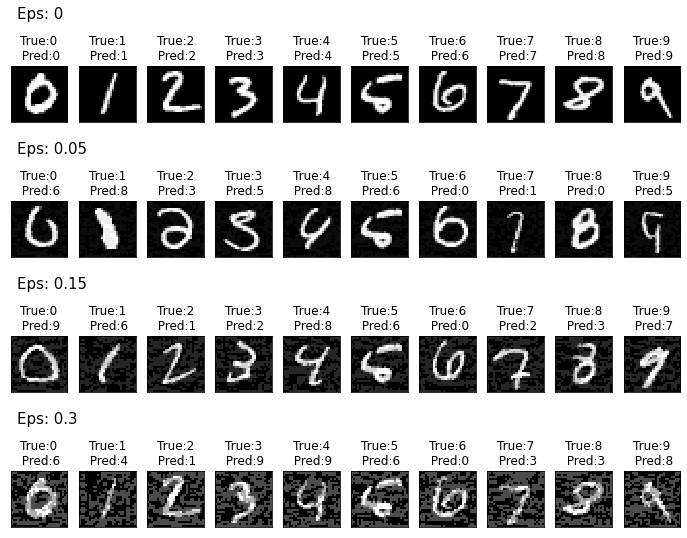

In [17]:
count=0
plt.figure(figsize=(12,12))
for i in range(len(all_examples)):
    adv_examples = all_examples[i]
    
    for j in range(len(adv_examples)):
        count+=1
        plt.subplot(5, 10, count)
        plt.xticks([], [])
        plt.yticks([], [])
        
        
        a,b, ex = adv_examples[j]
        plt.title("True:{}\n Pred:{}".format(a, b))
        plt.imshow(ex, cmap="gray")
    plt.text(-300, -15, "Eps: {}\n".format(epsilon_list[i]), fontsize=15)
# plt.tight_layout()                  

## 1.5: Analyzing the results (5 Points)

Please write a brief summary of your findings.  

* Does the attack always succeed (the model makes wrong prediction on the adversarial sample)? What is the relationship between the attack success rate and the perturbation budget?
* How about the computation cost of the attack? (you can report the time in second) 
* Does the attack require white-box access to the model?
* Feel free to report your results via tables or figures, and mention any other interesting observations 



**Your answers go here**


*   Attack doesn't always succeed especially for low perturbation budget. For example, perturbation budget of 0.05 gives a drop of 3% in accuracy (99% to 96.38%). We observe that the attack success rate is tightly coupled with the perturbation budget. More the epsilon value, higher will be the attack success rate. 
*   The computation costs of the attacks is given below in a table format.


*   The attacker requires white-box access to the model as he needs the gradients with respect to the input data, which can only be achieved if he has full access to the training weights and loss functions.
*   We have plotted a figure below which shows **'Accuracy vs Epsilon'**. We see that accuracy drops sharply after epsilon value of 0.15.





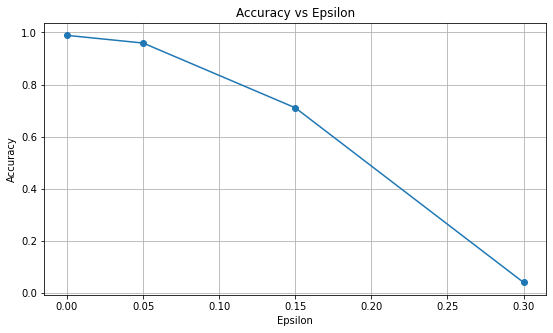

In [18]:
fig = plt.figure(figsize=(9,5))
plt.plot(list(epsilon_acc.keys()), list(epsilon_acc.values()), marker='o')
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [19]:
!pip install ipy_table
from ipy_table import *
temp = []
run_time_list = []

# convert the dictionary to a list
run_time_list.append(['Epsilon','Run-time'])
for key, value in epsilon_run.items():
    temp = [key,value]
    run_time_list.append(temp)


# create table with make_table
make_table(run_time_list)

Epsilon,Run-time
0,15.2224
0.0500,15.2128
0.1500,15.6860
0.3000,15.5878


# 2. Defending an ML model (35 points) 

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. 


## 2.1: Implementing the adversarial training defense (20 Points)

* We would like to ask you to implement the adversarial training defense (https://arxiv.org/pdf/1412.6572.pdf) mentioned in the lecture. 

* You can use the **FGSM adversarial training** method (i.e., train on FGSM examples). 

* You can also check the adversarial training implementation in other papers, e.g., http://proceedings.mlr.press/v97/pang19a/pang19a.pdf 

* Choose a certain **maximum perturbation budget** during training that is in the middle of the range you have experimented with before. 

* We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

**Hint:** You can save the checkpoint of the defended model as we would need it to for the third part of this exercise.


### Model Fitting

In [20]:
# Prepare the data
print("Loading dataset....")


# Loading MNIST dataset using torchvision.datasets
train_set = torchvision.datasets.MNIST(root='.', train=True, transform=transforms.ToTensor(), download=True)
train_set, valid_set = torch.utils.data.random_split(train_set, [50000, 10000])
test_set = torchvision.datasets.MNIST(root='.', train=False, transform=transforms.ToTensor(), download=True)

data = {
    'train_set': train_set,
    'valid_set': valid_set,
    'test_set': test_set
}
print('Done')

Loading dataset....
Done


In [21]:
class Parameters:

    # Model parameters
    dropout: float = 0.3
    save_model: bool = True
    out_dir: str = 'cnn_adv_model'

    # Training parameters
    epochs: int = 20
    batch_size: int = 100
    reg: float = 0.001
    learning_rate: float = 2e-3
    
    # FGSM param
    train_epsilon=0.15
    

class Run:
    '''Training, evaluation and metrics calculation'''
    
    def update_lr(optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr 
    
    @staticmethod
    def train(model, data, params):

        # Initialize loaders
        loader_train = DataLoader(
                         dataset=data['train_set'],
                         batch_size=params.batch_size,
                         shuffle=True)
        loader_valid = DataLoader(
                         dataset=data['valid_set'],
                         batch_size=params.batch_size,
                         shuffle=False)
        
        loader_test = DataLoader(
                         dataset=data['test_set'],
                         batch_size=params.batch_size,
                         shuffle=False)


        # FGSM param
        epsilon = params.train_epsilon
        # Define optimizer
        lr = params.learning_rate
        learning_rate_decay = 0.95
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=params.reg)
        
        # Loss function
        criterion = nn.CrossEntropyLoss()

        # Tracking best validation accuracy
        best_accuracy = 0
        
        print("\nStart adversarial training...")
        print(f"Epsilon:{params.train_epsilon}")
        print(f"{'Epoch':^7} | {'Train Acc':^10} | {'Val Loss':^10} | {'Val Acc':^9} | {'Test Acc':^9} | {'Elapsed':^9}")
        print("-"*80)
    
        # Starts training phase
        train_loss_list = []
        val_loss_list = []
        test_acc_list = []
        
        
        for epoch in range(params.epochs):
            # =======================================
            #               Training
            # =======================================

            # Tracking time and loss
            t0_epoch = time.time()
            total_loss = 0
            adv_train_accuracy = 0
            
            # Put the model into training mode
            model.train()
        
            # Starts batch training
            for x_batch, y_batch in loader_train:
                #=============== Normal Training ===============
                # Load batch to GPU
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                x_batch.requires_grad = True
                # Feed the model
                y_pred = model(x_batch)

                # Compute loss and accumulate the loss values
                loss = criterion(y_pred, y_batch)

                # Clean gradients
                optimizer.zero_grad()

                # Gradients calculation
                loss.backward()

                # Gradients update
                optimizer.step()
                data_grad = x_batch.grad.data
                #=================================================
                
                #=============== Adversarial Training ===============
                x_batch = fgsm_attack(x_batch, params.train_epsilon, data_grad)
                # Load batch to GPU
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                
                # Feed the model
                y_pred_adv = model(x_batch)

                # Compute loss and accumulate the loss values
                loss = criterion(y_pred_adv, y_batch)
                total_loss += loss.item()

                # Clean gradients
                optimizer.zero_grad()

                # Gradients calculation
                loss.backward()

                # Gradients update
                optimizer.step()
                #=======================================================
                
                # Training metrics (for one batch)
                corrects_adv = (torch.max(y_pred_adv, 1)[1].view(y_batch.size()).data == y_batch.data).sum()
                acc = 100.0 * corrects_adv/loader_train.batch_size
                adv_train_accuracy += acc

            # Calculate the average loss over the entire training data for entire batch
            avg_train_loss = total_loss / len(loader_train)
            train_loss_list.append(avg_train_loss)
            
            # Compute accuracy averaged over all batches for an epoch
            adv_train_accuracy = adv_train_accuracy / len(loader_train)
            
            lr *= learning_rate_decay
            update_lr(optimizer, lr)
            
            # =======================================
            #               Evaluation
            # =======================================
            
            # After the completion of each training epoch, measure the model's
            # performance on our validation set.
        
            # Validation metrics
            val_loss, val_accuracy = evaluation(model, loader_valid, epsilon)
            _, test_accuracy = evaluation(model, loader_test, epsilon)
            val_loss_list.append(val_loss)
            test_acc_list.append(test_accuracy)
            
            # Track the best accuracy
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                # Save the best model
                os.makedirs(params.out_dir, exist_ok=True)
                if params.save_model:
                    # Also keeping the best model with one name to make it easy to load it later
                    PATH = params.out_dir + "/best_defended_model" + ".pth"
                    torch.save(model.state_dict(), PATH)
                    PATH = params.out_dir + "/adv_model_epochs_" + str(epoch+1) +"_batch_size_" + str(params.batch_size) + ".pth"
                    torch.save(model.state_dict(), PATH)


            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            print(f"{epoch + 1:^7} | {adv_train_accuracy:^10.2f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            
            
        print("\n")
        print(f"Training complete! \nBest accuracy at 0.15 epsilon training: {best_accuracy:.2f} %.")
        print("Best model saved: ",PATH)
        return train_loss_list, val_loss_list, test_acc_list,PATH


def evaluation(model, loader_valid, epsilon):

    # Set the model in evaluation mode
    model.eval()
    corrects, avg_loss = 0, 0
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Start evaluation phase   
    for x_batch, y_batch in loader_valid:
        
        x_batch = x_batch.to(DEVICE); 
        y_batch = y_batch.to(DEVICE)
        x_batch.requires_grad = True
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        model.zero_grad()
        loss.backward()
        
        data_grad = x_batch.grad.data
        x_batch = fgsm_attack(x_batch, epsilon, data_grad)
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)

        avg_loss += loss.item()
        corrects += (torch.max(y_pred, 1) [1].view(y_batch.size()).data == y_batch.data).sum()
            
    size = len(loader_valid.dataset)
    avg_loss /= size
    accuracy = 100.0 * corrects/size
    
    return avg_loss, accuracy

In [23]:
# Initialize the model
DEVICE = device
start = time.time()
model = Net(input_size, hidden_layers, num_classes)
model.to(DEVICE)
# print(modael)

# Train and Evaluate the pipeline
train_loss_list, val_loss_list, test_acc_list, PATH = Run().train(model, data, Parameters)
end = time.time()
print("*** Training Complete ***")
print("Training runtime: {:.2f} s".format(end-start))


Start adversarial training...
Epsilon:0.15
 Epoch  | Train Acc  |  Val Loss  |  Val Acc  | Test Acc  |  Elapsed 
--------------------------------------------------------------------------------
   1    |   83.87    |  0.003816  |   87.11   |   87.88   |   6.01   
   2    |   90.64    |  0.003074  |   89.71   |   90.82   |   5.83   
   3    |   91.58    |  0.002811  |   90.92   |   91.41   |   5.89   
   4    |   92.29    |  0.002796  |   90.82   |   91.63   |   6.11   
   5    |   92.46    |  0.002497  |   91.94   |   92.28   |   6.02   
   6    |   92.83    |  0.002594  |   91.71   |   92.49   |   5.92   
   7    |   93.16    |  0.002461  |   91.96   |   92.92   |   6.11   
   8    |   93.19    |  0.002527  |   91.94   |   92.64   |   5.91   
   9    |   93.42    |  0.002409  |   91.96   |   92.43   |   5.87   
  10    |   93.47    |  0.002326  |   92.29   |   93.17   |   5.93   
  11    |   93.69    |  0.002330  |   92.52   |   93.49   |   5.98   
  12    |   93.66    |  0.002216  |

## 2.2: Evaluation (10 Points)

* Craft adversarial examples using the **defended** model. This entails at least 1,000 examples crafted via FGSM. 
    * Create one set using a budget that is **less than (within)** the one used in training.
    * Create another set using a budget that is **higher than** the one used in training. 
    * You can use two values of epsilons from question 1.3 
    
* Evaluate the **defended** model on these two adversarial examples sets. 


In [24]:
eps_lb = 0.05
eps_hb = 0.3
loader_test = DataLoader(
                         dataset=data['test_set'],
                         batch_size=Parameters.batch_size,
                         shuffle=False)

model = Net(input_size, hidden_layers, num_classes).to(device)

# Load the best model and test the defended model on two perturbation budget [0.05, 0.3]
state_dict = torch.load(PATH)
model.load_state_dict(state_dict)
model.eval()
_, test_accuracy_lb = evaluation(model, loader_test, eps_lb)
_, test_accuracy_hb = evaluation(model, loader_test, eps_hb)
print(f"Test acc on lower perturbation budget(eps=0.05): {test_accuracy_lb:.2f}%.")
print(f"Test acc on higher perturbation budget(eps=0.3): {test_accuracy_hb:.2f}%.")

Test acc on lower perturbation budget(eps=0.05): 97.68%.
Test acc on higher perturbation budget(eps=0.3): 65.58%.


## 2.3 Discussion (5 points)

* How successful was the defense against the attack compared to the undefended model? How do you interpret the difference?
* How did the two sets differ?

**Your answers go here**
The defended sucessfully managed to combat the adervsarial sample while testing. We trained the adversarial model on clean data as well as adervarial samples on a fixed perturbation budget i.e. $\epsilon=0.15$. We further tested the model on perturbed images for $\epsilon=0.05$ and $\epsilon=0.3$. 

|Epsilon | Test acc|
|--------|---------|
|0.05    |97.76%    |
|0.15    |93.32%    |
|0.3     |64.09%    |

We observe that increasing the perturbation budget more than the model was trained on results in a reduced test accuracy. We think the difference is due to the fact that the model has already seen perturbations of and below a particular epsilon type and thus model does not gets attacked with epsilon lower than 0.15. But when we increase the epsilon accuracy decreases because the images get more perturbations added than the model was trained on and thus with higher epsilon we are able to attack the model again. Although not as severely as the undefended model.


One major issue with this type of defense mechanism is that it works on a specific type of attack that the model is trained on.

# 3: I-FGSM attack (35 points) 

* FGSM is one of the simplest and earliest attacks. Since then, many more advanced attacks have been proposed. 
* One of them is the Iterative-FGSM (https://arxiv.org/pdf/1607.02533.pdf), where the attack is repeated multiple times.
* In this part, we ask you to please implement the iterative FGSM attack. 



## 3.1: Implementing the I-FGSM attack (10 Points)

**Hints**: 

* Your code should have an attack loop. At each step, the FGSM attack that you have implemented before is computed using a small step.
* After each step, you should perform a per-pixel clipping to make sure the image is in the allowed range, and that the perturbation is within budget.


In [25]:
def iterative_fgsm(images, model, labels, alpha, n_iters, epsilon):

  original_images = images.clone().detach().to(images.device)
  images.requires_grad = True
  for i in range(n_iters):
    model.zero_grad()

    output = model(images)
    loss = nn.CrossEntropyLoss()(output, labels)
    loss.backward()

    # Getting the perturbation
    perturbation = alpha*images.grad.data.sign()

    # Making the overall perturbations for the image within the perturbation budget.
    perturbation = torch.clamp(images.data + perturbation - original_images, -epsilon, epsilon)

    # Adding the overall perturbation to the image
    images.data = original_images + perturbation

    # Cliping image in the required range
    images.data = torch.clamp(images.data, 0, 1)

    images.grad.data.zero_()

  return images.detach()

## 3.2: Attack the undefended model (5 Points)

* We will first attack the **undefended model** (i.e., without adversarial training).

* Choose one perturbation budget from Question **1.3** for comparison. 

    * Hint: A simple way to choose the small step is to divide the total budget by the number of steps (e.g., 10).

* Please generate 1000 adversarial examples using the **undefended** model and the **I-FGSM** you implemented. 

* Please compute the accuracy of the adversarial set on the **undefended** model. 

In [26]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=False)

In [27]:
# Loading the undefended model trained in part 1.

model_undefended = Net(input_size, hidden_layers, num_classes).to(device)
PATH_UNDEFENDED = "undefended_model.pth"
state_dict = torch.load(PATH_UNDEFENDED, map_location=device)
model_undefended.load_state_dict(state_dict)
model_undefended.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=3136, out_features=10, bias=True)
)

In [28]:
# Function to do iterative fgsm attack on the models and then compute accuracy using the attacked images.
def test_model_on_iterative_fgsm_attack(model, alpha, n_iters, epsilon):
    correct = 0
    for (images, labels) in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        per_image = iterative_fgsm(images, model, labels, alpha=alpha, n_iters=n_iters, epsilon=epsilon)
        pert_output = model(per_image)
        (_, perturb_predicted) = torch.max(pert_output.data, 1)

        # Adding 1 to correct because we have set batch size to 1 so we are processing each image one by one        
        if perturb_predicted.item() == labels.item():
                correct += 1
        
    final_acc = correct/float(len(test_loader))
    print("Alpha:{}, n_iters: {}, Epsilon: {}\tTest Accuracy = {} / {} = {}".format(alpha, n_iters, epsilon, correct, len(test_loader), final_acc))
    return final_acc

In [29]:
# Choosing epsilon 0.15 for comparison with Task 1. Alpha choosen as (Epsilon / num_iterations)
start_time = time.time()
test_model_on_iterative_fgsm_attack(model_undefended, alpha=0.015, n_iters=10, epsilon=0.15)
print("Time taken: ", time.time() - start_time)

Alpha:0.015, n_iters: 10, Epsilon: 0.15	Test Accuracy = 4783 / 10000 = 0.4783
Time taken:  124.67702889442444


In [30]:
start_time = time.time()
test_model_on_iterative_fgsm_attack(model_undefended, alpha=0.015, n_iters=20, epsilon=0.15)
print("Time taken: ", time.time() - start_time)

Alpha:0.015, n_iters: 20, Epsilon: 0.15	Test Accuracy = 3631 / 10000 = 0.3631
Time taken:  240.11939883232117


In [31]:
start_time = time.time()
test_model_on_iterative_fgsm_attack(model_undefended, alpha=0.015, n_iters=30, epsilon=0.15)
print("Time taken: ", time.time() - start_time)

Alpha:0.015, n_iters: 30, Epsilon: 0.15	Test Accuracy = 3374 / 10000 = 0.3374
Time taken:  365.5865681171417


In [32]:
start_time = time.time()
test_model_on_iterative_fgsm_attack(model_undefended, alpha=0.005, n_iters=10, epsilon=0.05)
print("Time taken: ", time.time() - start_time)

Alpha:0.005, n_iters: 10, Epsilon: 0.05	Test Accuracy = 9523 / 10000 = 0.9523
Time taken:  120.63755226135254


In [33]:
start_time = time.time()
test_model_on_iterative_fgsm_attack(model_undefended, alpha=0.03, n_iters=10, epsilon=0.3)
print("Time taken: ", time.time() - start_time)

Alpha:0.03, n_iters: 10, Epsilon: 0.3	Test Accuracy = 1 / 10000 = 0.0001
Time taken:  123.57673764228821


### 3.2.1: Findings and comparison with FGSM (8 points)

* Please report your findings. How successful was the attack? 

* What do you expect when increasing the number of steps? (you can experiment with different parameters of the attack and report your findings) 

* Compare with the basic FGSM. Using the same perturbation budget and using the same model, which attack is more successful? Why do you think this is the case? What about the computation time?

* Feel free to report any interesting observations. 

The attack on the undefended model was very successful. In all of the cases the attack was able to reduce the accuracy of the model. We observed that increasing the number of steps while keeping epsilon and alpha constant lead to a more severe attack and reduced the accuracy even further. 

The table below shows the accuracy of the model on the IFGSM attack. Also some values are written here for the FGSM attack from Task 1 so that comparison can be done:

| Attack | Parameters | Accuracy | Runtime |
| --- | ----------- | | |
| FGSM | $ϵ$=0.05 | 96.38% | 30 |
| FGSM | $ϵ$=0.15 | 71.08% | 30 |
| FGSM | $ϵ$=0.30 | 3.83% | 30 |
| IFGSM | $α$=0.005 , n_iters=10 , $ϵ$=0.05 | 95.72% | 212 |
| IFGSM | $α$=0.015 , n_iters=10 , $ϵ$=0.15 | 43.34% | 212 |
| IFGSM | $α$=0.015 , n_iters=20 , $ϵ$=0.15 | 29.86% | 412 |
| IFGSM | $α$=0.015 , n_iters=30 , $ϵ$=0.15 | 27.22% | 611 |
| IFGSM | $α$=0.03 , n_iters=10 , $ϵ$=0.3 | 0% | 211 |

In comparison with basic FGSM, using the same perturbation budget, the attack was always better with the iterative method and lead to a lower accuracy of the model. For example, for perturbation budget epsilon=0.15, in case of FGSM the accuracy was 71.08%, while with Iterative-FGSM, the accuracy for epsilon=0.15 was 43.34%. We obtained similar results for other epsilon values where Iterative-FGSM attack lead to a lower test accuracy as compared to the FGSM attack.  

We think this is the case because in case of Iterative-FGSM, the model is taking smaller but more fine grained steps to increase the loss value, thus it is able to find better perturbations to attack the model by slowy navigating the loss surface instead of just going in a single step like in FGSM. Thus the  attack gets better because of smaller but better and fine-grained navigation of loss surface.

The computation of Iterative FGSM was always much more than the FGSM attack. The time taken by iterative attacks was a lot higher than the one by FGSM attack. This further increased with the number of steps. The runtime can be seen in the table above.

## 3.3: Attack the defended model (5 poinst) 

* In the previous question, we attacked the **undefended model**. 

* Now, we want to explore how successful the previous implemented defense (FGSM adversarial training) is againts this new attack. (we will not implement a new defense here, we will be reusing your previous checkpoint of the **defended model**)


* Use the **defended model** to create one set of adversarial examples. Use a perturbation budget from Question **2.2** for comparison.  

In [34]:
# Loading the defended model.

model_defended = Net(input_size, hidden_layers, num_classes).to(device)
PATH_DEFENDED = "cnn_adv_model/best_defended_model.pth"
state_dict = torch.load(PATH_DEFENDED, map_location=device)
model_defended.load_state_dict(state_dict)
model_defended.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=3136, out_features=10, bias=True)
)

In [35]:
# Passing the defended model to the previously defined function
start_time = time.time()
test_model_on_iterative_fgsm_attack(model_defended, alpha=0.015, n_iters=10, epsilon=0.15)
print("Time taken: ", time.time() - start_time)

Alpha:0.015, n_iters: 10, Epsilon: 0.15	Test Accuracy = 9115 / 10000 = 0.9115
Time taken:  124.56477499008179


In [36]:
start_time = time.time()
test_model_on_iterative_fgsm_attack(model_defended, alpha=0.015, n_iters=20, epsilon=0.15)
print("Time taken: ", time.time() - start_time)

Alpha:0.015, n_iters: 20, Epsilon: 0.15	Test Accuracy = 9018 / 10000 = 0.9018
Time taken:  242.42529106140137


In [37]:
start_time = time.time()
test_model_on_iterative_fgsm_attack(model_defended, alpha=0.015, n_iters=30, epsilon=0.15)
print("Time taken: ", time.time() - start_time)

Alpha:0.015, n_iters: 30, Epsilon: 0.15	Test Accuracy = 9003 / 10000 = 0.9003
Time taken:  360.34209752082825


In [38]:
start_time = time.time()
test_model_on_iterative_fgsm_attack(model_defended, alpha=0.005, n_iters=10, epsilon=0.05)
print("Time taken: ", time.time() - start_time)

Alpha:0.005, n_iters: 10, Epsilon: 0.05	Test Accuracy = 9757 / 10000 = 0.9757
Time taken:  121.63726735115051


In [39]:
start_time = time.time()
test_model_on_iterative_fgsm_attack(model_defended, alpha=0.03, n_iters=10, epsilon=0.3)
print("Time taken: ", time.time() - start_time)

Alpha:0.03, n_iters: 10, Epsilon: 0.3	Test Accuracy = 1362 / 10000 = 0.1362
Time taken:  120.40184235572815


### 3.3.1: Discussion (7 points) 
* Please report your results. How successful was the attack on the defended model? 
* Compare it with the success of the FGSM attack on the defended model. What do you observe? How do you interpret the difference? 
* How do you think you can improve the defense against I-FGSM attack?


* Feel free to state any interesting findings you encountered during this project.

The attack on the defended model was not very successfull. The IFGSM attacked reduced accuracy but not by much. Especially when the perturbation budget was within the range on which the model was trained on, the Iterative FGSM attack was not able to reduce the accuracy by a large amount. There was a drop in accuracy when using the epsilon=0.15 for by using IFGSM (2-3 % accuracy decrease) but it was not as sharp as the decrease in accuracy for the undefended model. 

The table below shows the accuracy of the defended model on the Iterative FGSM attacks. We also add results from Task 2 for comparison here. Note that the defended model was trained in Task 2 with epsilon=0.15

| Attack | Parameters | Accuracy |
| --- | ----------- | | 
| FGSM | $ϵ$=0.05 | 97.76% |
| FGSM | $ϵ$=0.15 | 93.32% |
| FGSM | $ϵ$=0.30 | 64.09% |
| IFGSM | $α$=0.005 , n_iters=10 , $ϵ$=0.05 | 97.61% |
| IFGSM | $α$=0.015 , n_iters=10 , $ϵ$=0.15 | 91.53% |
| IFGSM | $α$=0.015 , n_iters=20 , $ϵ$=0.15 | 90.63% |
| IFGSM | $α$=0.015 , n_iters=30 , $ϵ$=0.15 | 90.52% |
| IFGSM | $α$=0.02 , n_iters=10 , $ϵ$=0.2 | 5.77% |

We saw in task 2 that FGSM attack was not successful on the defended model. We think that was because the model was trained on FGSM generated examples and model then became resistant to that type of attacks (within the perturbation budget on which the model was trained on). The iterative FGSM was still able to reduce the accuracy on the defended model. The decrease in accuracy in IFGSM might be due to more steps taken in IFGSM which found some of the examples on which the attack was possible by more fine grained attack. The more fine grained steps in IFGSM helped to reduce the accuracy for the defended model. We also observed that increasing the number of steps in IFGSM also didnt help in reducing the accuracy by a lot. We also observe that as soon as we increase the perturbation budget from which the model was trained on, the accuracy of the model again starts decreasing and the model gets attacked.

To improve the defense againt the IFGSM attack, we can train on examples generated using the IFGSM attack. We should also use a higher perturbation budget to train the model. But in this case also some examples or some attack vectors might be missed by the model and newer attacks might be generated.